# Saving and Loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import torch

import swyft

In [4]:
device = "cpu"
n_training_samples = 3000
n_parameters = 2
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)
observation_key = "y"

n_posterior_samples_for_truncation = 10_000
n_rejection_samples = 10_000

In [5]:
def model(v):
    a, b = v
    x = np.linspace(-1, 1, 100)
    y = a*x + b
    return {observation_key: y}

v_o = np.zeros(n_parameters)
observation_o = model(v_o)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

In [6]:
simulator = swyft.Simulator(
    model, 
    n_parameters, 
    sim_shapes=observation_shapes
)

low = -1 * np.ones(n_parameters)
high = 1 * np.ones(n_parameters)
prior = swyft.get_uniform_prior(low, high)

store = swyft.Store.memory_store(simulator)
store.add(n_training_samples, prior)
store.simulate()

def noise(obs, v, sigma=0.05):
    y = obs[observation_key]
    n = np.random.randn(*y.shape)*sigma
    return {observation_key: y+n}

Creating new store.
Store: Adding 3056 new samples to simulator store.


In [7]:
dataset = swyft.Dataset(
    n_training_samples, 
    prior, 
    store, 
    simhook=noise
)

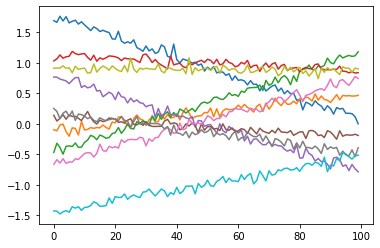

In [8]:
for i in range(10):
    plt.plot(dataset[i][0][observation_key])

In [9]:
network_1d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)
mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [10]:
mre_1d.train(dataset)

training: lr=0.0005, epoch=25, validation loss=0.4911


In [11]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

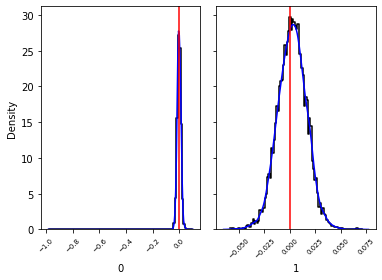

In [12]:
_ = swyft.hist1d(samples_1d, kde=True, truth=v_o)

## Saving

Saving is straightforward

In [13]:
prior_filename = "example3.prior.pt"
dataset_filename = "examples3.dataset.pt"
mre_1d_filename = "examples3.mre_1d.pt"

prior.save(prior_filename)
dataset.save(dataset_filename)
mre_1d.save(mre_1d_filename)

## Loading

Loading is different for different object types. The prior and dataset are simple, but the network is a bit more involved. One must first instantiate a network, then load the saved version into it.

In [14]:
prior_loaded = swyft.Prior.load(prior_filename)
dataset_loaded = swyft.Dataset.load(
    filename=dataset_filename, 
    store=store, 
    simhook = noise
)


network_new = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_1d_loaded = swyft.MarginalRatioEstimator.load(
    network=network_new,
    device=device,
    filename=mre_1d_filename,
)

### Loading posteriors

There is no option to save / load a posterior because you can simply create one from the prior and the `MarginalRatioEstimator`. One can also save a `Bound` object and load it, then give the loaded object to `MarginalPosterior`. `Bound` objects are simple to save and load.

In [15]:
post_new = swyft.MarginalPosterior(mre_1d_loaded, prior_loaded, bound=None)
samples_new = post_new.sample(n_rejection_samples, observation_o)

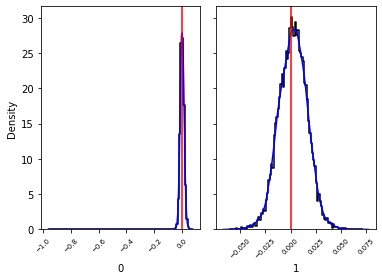

In [16]:
_ = swyft.hist1d(samples_new, kde=True, truth=v_o)